# К вопросу прогнозирования распространения COVID - 19 на территории Российской Федерации

In [2]:
# Подключение необходимых библиотек
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np;
import scipy as sc;
import statsmodels.api as sm;
import matplotlib.pyplot as plt;
from pylab import *

# Загрузка данных

data=pd.read_csv('../data/01_Data03.csv');
data.index = pd.Index(data.date);
A=data['RUS'];
A.index = pd.DatetimeIndex(A.index.values);

## 1.Введение

### В последнее время из-за интенсивного распространения вирусной инфекции COVID-19 приобрела актуальность и своевременность проблема построения методологии прогнозирования роста числа заболеваний, как по всему миру в целом, так и в РФ в частности.

### Из литературных источников известно, что одним из наиболее часто используемых методов прогнозирования распространений эпидемий является использование моделей, построенных на базе дифференциальных уравнений, например, известная модель гибели и размножения или модель хищник-жертва, решение которой можно представить в следующем виде:
$$
N(t) = N(0)\cdot exp\left(\int [a(t) - b(t)]dt\right)
$$

### где $N(t)$ - изменение количества заразившихся с течением времени t, $N(0)$ - начальное значение, $a(t)$ и $b(t)$ - коэффициенты модели, в том числе обладающие ярко выраженной нелинейностью.

### Однако, принимая во вниание, что имеющиеся в распоряжении исследователя данные носят дискретный характер, использование для построения прогнозирующих моделей общепринятых моделей, базирующихся на дифференциальных уравнениях является невозможным, т.к. исследуемая функция претерпевает разрыв.

## 2. Основная часть

### Рассмотрим процесс изменения количества заразившихся вирусной инфекцией COVID - 19, на примере РФ (см. график ниже).

In [19]:
A.describe() # общие данные о процессе.

count       94.000000
mean      6378.531915
std      14855.421424
min          0.000000
25%          2.000000
50%         17.000000
75%       2667.000000
max      68622.000000
Name: RUS, dtype: float64

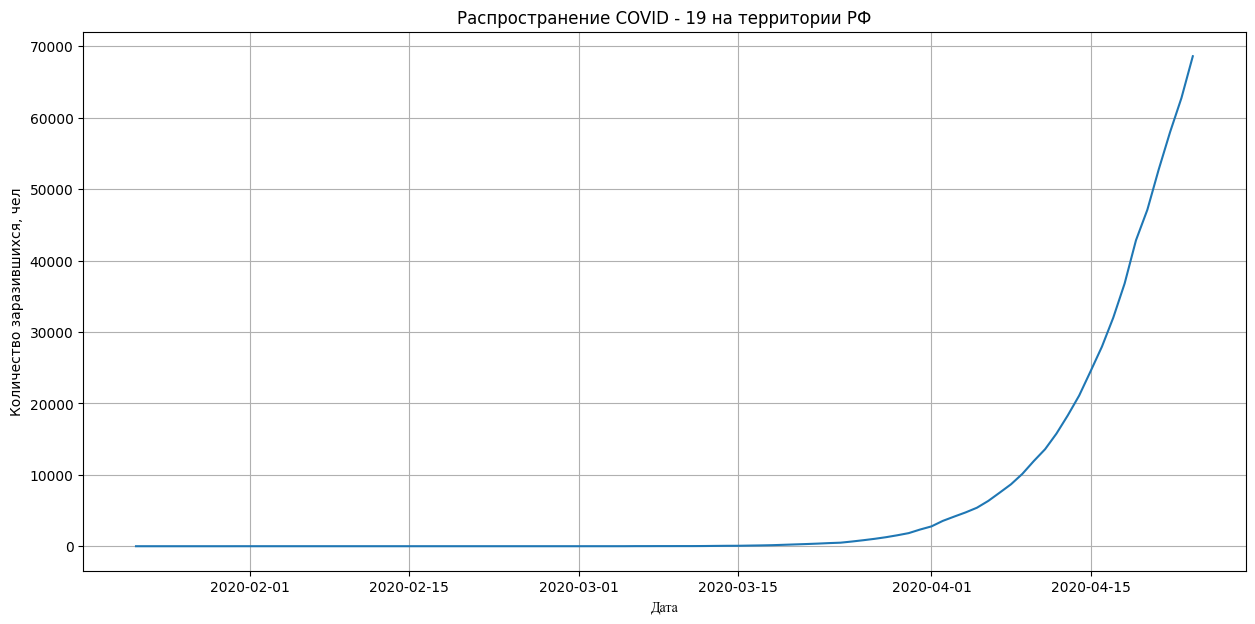

In [20]:
plt.figure(figsize=(15,7));
plt.title('Распространение COVID - 19 на территории РФ');
plt.plot(A);
plt.grid();
xlabel('Дата', {'fontname':'Times New Roman'})
ylabel('Количество заразившихся, чел')
plt.show()

### Представим  имеющуюся последовательность данных в виде следующего вектора: 

$$
x_t =[x_1,x_2,...,x_i]^T
$$, 
#### где $x_i$ - $i$ - е значение заразившихся в день $i$,  $i=1,2,3,...,n$ - дискретные моменты времени, $n$ - количество дней, $T$ - знак транспонирования. 
### Изменение $x_t$ с течением времени представляет одномерный скалярный процесс. Поэтому, очевидно, что математическая задача построения прогнозирующей модели может быть вполне сведена к задаче нахождения аналитического описания процесса изменения исследуемого процесса с течением времени.

### Допустим, что текущее значение количества заразившихся в момент времени $i$ содержит в себе информацию о популяции в целом (объем, уровень жизни, внешние воздействия и т.д.), а также является функцией от предшествующих значений в виде полумарковского процесса.
### Проверим предположение о наличии взаимосвязи между текущим и предшествующими значениями исследуемого временного ряда. Для этого проведем оценку влияния предшествующих значений количества заразившихся вирусной инфекцией на текущее значение, используя автокорреляционную функцию. 

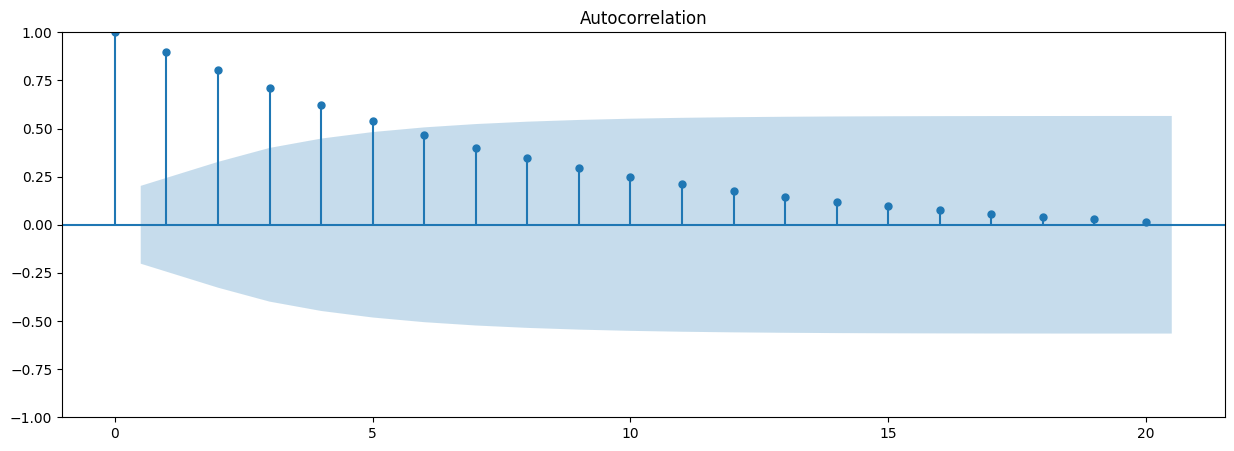

In [21]:
from statsmodels.tsa.api import acf, pacf, graphics # Подключение библиотеки statsmodels.tsa.api
fig = plt.figure(figsize=(15,5)) # Построение функции автокорреляции
ax1 = fig.add_subplot(111)
fig = sm.graphics.tsa.plot_acf(A.values.squeeze(), lags=20, ax=ax1)

### Из анализа автокорреляции следует, что на каждое текущее значение наиболее сильное влияние оказывают первые пять предшествующих значений временного ряда, однако если снизить порог значимости до 0.2, то в рассмотрение можно включить первые дясять значений. Последнее, в свою очередь, можно было бы использовать как основание для построения авторегрессионной модели, однако авторегрессионная модель предполагает выполнение условий стационарности исследуемого ряда и отсутствия тренда. В данных явно присутствует нелинейный тренд. Поэтому проверим данные на стационарность. Для этого оценим изменение выборочного среднего значения ряда и выборочной дисперсии, а также определим значение критерия Дики-Фуллерадля для уровня значимости 95%.

In [22]:
#Определение критерия Дики-Фуллера:
from statsmodels.tsa.stattools import adfuller # Подключение библиотеки statsmodels.tsa

result = adfuller(A[30::-1]) # Оценка значения критерия ДФ, первые 30 значений практически нули
print('ADF Statistic: {}'.format(result[0])) # Вывод результата
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -0.596284793999944
p-value: 0.8718193032778482
Critical Values:
	1%: -3.6699197407407405
	5%: -2.9640707407407407
	10%: -2.621171111111111


### Отметим, что рассчетное значение AD-теста значительно больше критического, что означает явную нестационарность исследуемого ряда. 

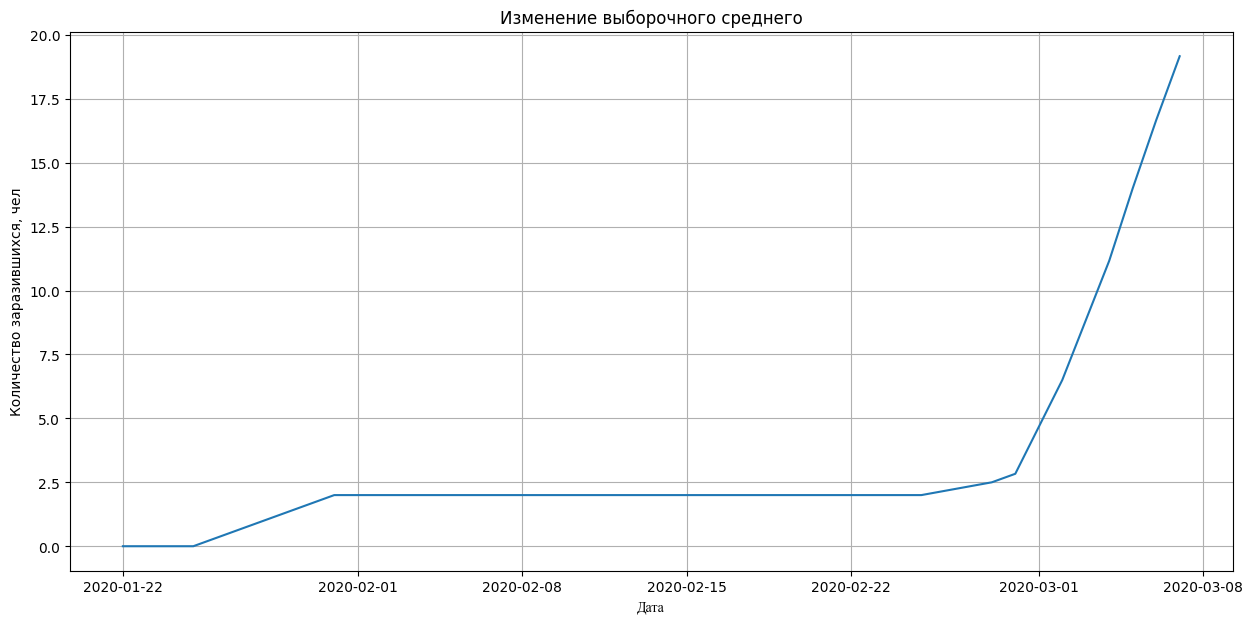

In [29]:
# Оценка выборочного среднего и выборочной дисперсии
rolling_mean = A[50::-1].rolling(window = 6).mean();
plt.figure(figsize=(15,7));
plt.plot(rolling_mean);
plt.title('Изменение выборочного среднего');
plt.grid();
xlabel('Дата', {'fontname':'Times New Roman'})
ylabel('Количество заразившихся, чел')
plt.show();

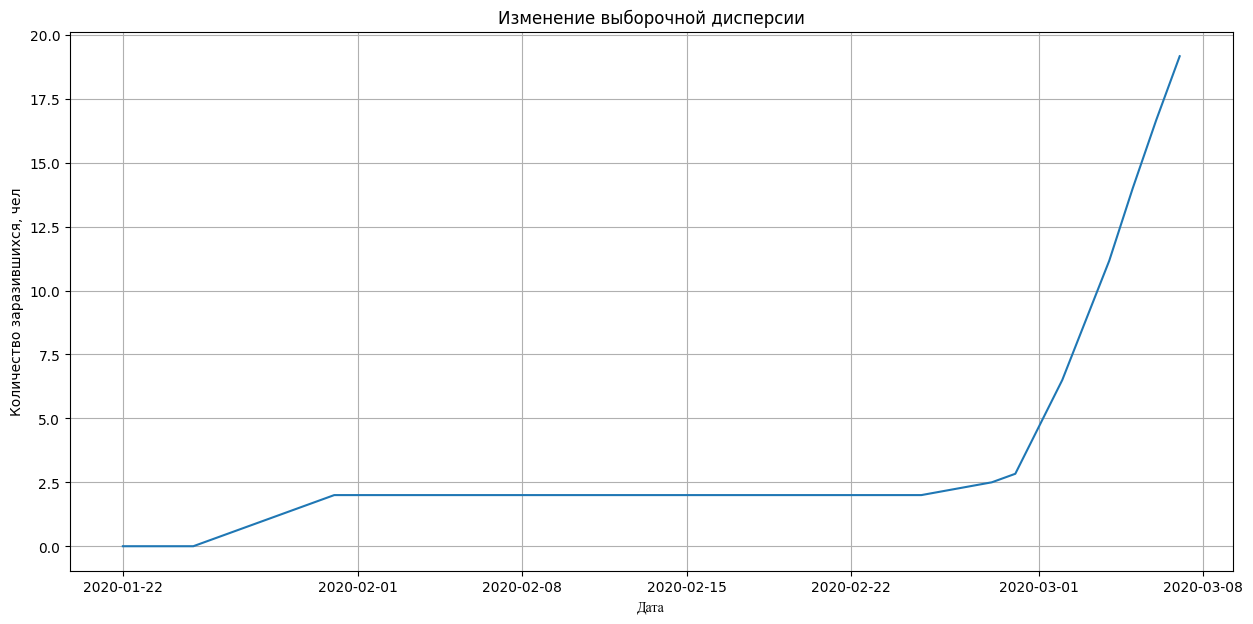

In [30]:
rolling_var = (A[50::1].rolling(window = 6).var())**0.5;
plt.figure(figsize=(15,7));
plt.plot(rolling_mean);
plt.title('Изменение выборочной дисперсии');
plt.grid();
xlabel('Дата', {'fontname':'Times New Roman'})
ylabel('Количество заразившихся, чел')
plt.show();

### Анализ выборочных средних и дисперсий также подтверждает нестационарность ряда, что отвергает возможность использования авторегрессионной модели для описания исследуемых данных.

### Поэтому, принимая во внимание явный нестационарный характер исследуемого временного ряда, в качестве описательной прогнозирующей модели примем модель авторегрессии-проинтегрированного-скользящего-среднего (ARIMA(p,d,q)), которая имеет следующий вид:
\begin{equation} \label{eq1}
\Delta X_{i,t} =\mu _{0} +\alpha t+\gamma X_{i,t-1} +\sum _{j=1}^{p-1}\alpha _{j} \Delta X_{i,t-j} +\varepsilon _{t},
\end{equation}

### где $\Delta X_{t} =X_{t} -X_{t-1} $ - прирощение процесса, $\mu _{0} $,$\gamma $,$\alpha $,$\alpha _{j} $ линейный тренд и коэффициенты регрессии, $\varepsilon _{t} $ - остатки моделирования, $p$ - лаг модели, который может быть определен, например, путем анализа автокорреляционной и частной автокорреляционной функции или используя информацинный критерий Акаике (Akaike Information Criterion):
$$
AIC=T[\ln(RSS)] + 2n
$$


## 3. Построение модели
### 3.1 Определим порядок интегрирования модели (параметр $d$). Для этого построим графики первой, второй и третьей разностей процесса. 

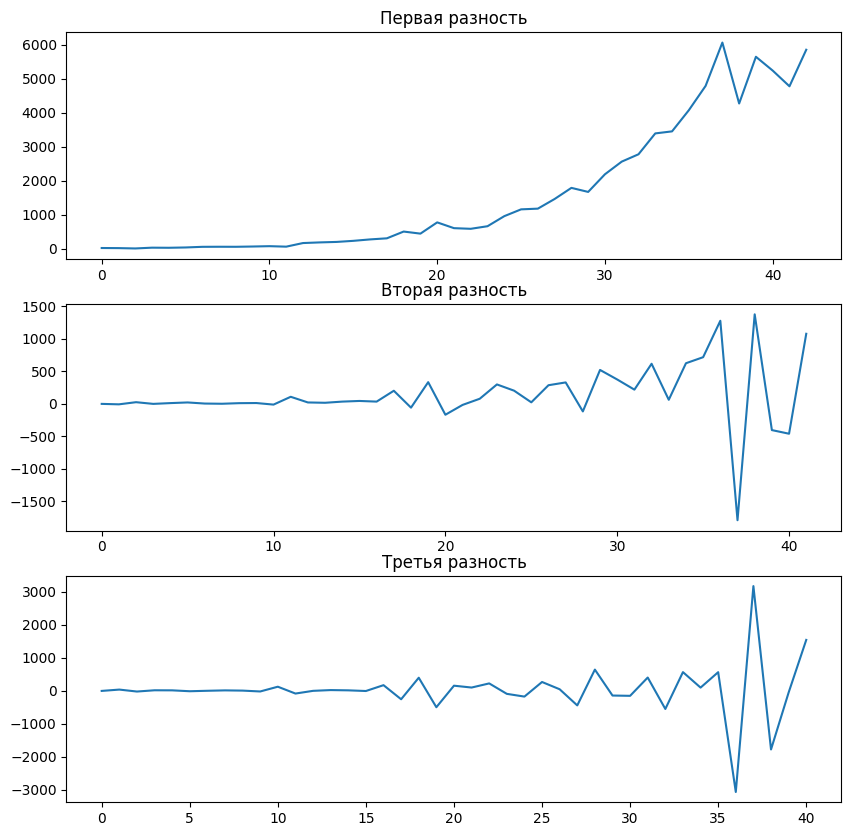

In [31]:
fig = plt.figure(figsize=(10,10))
plt.subplot(311)
plt.plot(diff(A[50::1]))
plt.title('Первая разность');
plt.subplot(312)
plt.plot(diff(diff(A[50::1])))
plt.title('Вторая разность');
plt.subplot(313)
plt.plot(diff(diff(diff(A[50::1]))))
plt.title('Третья разность');
plt.show()

### Из визуального анализа графиков, представленных на рисунке выше следует, что можно выдвинуть гипотезу о том, что вторая разность процесса преобразуется в сационарный процесс.
### Проверим выдвинутую гипотезу, используя AD-тест.

In [73]:
A =A.replace(0, np.nan).dropna();

In [74]:
#Определение критерия Дики-Фуллера:
from statsmodels.tsa.stattools import adfuller # Подключение библиотеки statsmodels.tsa
ddA = A.diff().diff().dropna()
result = adfuller(ddA[20:-1]) # Оценка значения критерия ДФ
print('ADF Statistic: {}'.format(result[0])) # Вывод результата
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

print("--"*25)
if result[1] < 0.05:
    print("Ряд стационарен (p-value < 0.05)")
else:
    print("Ряд нестационарен (p-value >= 0.05)")

ADF Statistic: -2.9680154399797085
p-value: 0.03799124873084798
Critical Values:
	1%: -3.5656240522121956
	5%: -2.920142229157715
	10%: -2.598014675124952
--------------------------------------------------
Ряд стационарен (p-value < 0.05)


### AD - тест подтверждает принятую гипотезу, ряд становится стационарным после второй разности с уровнем доверия 5%.

### 3.2 Определим параметры (порядок) авторегрессии и порядок скользящего среднего.
### Для оценки параметров авторегрессии и скользящего среднего построим частные автокорреляционные функции и автокорреляционные функции разностей процесса.

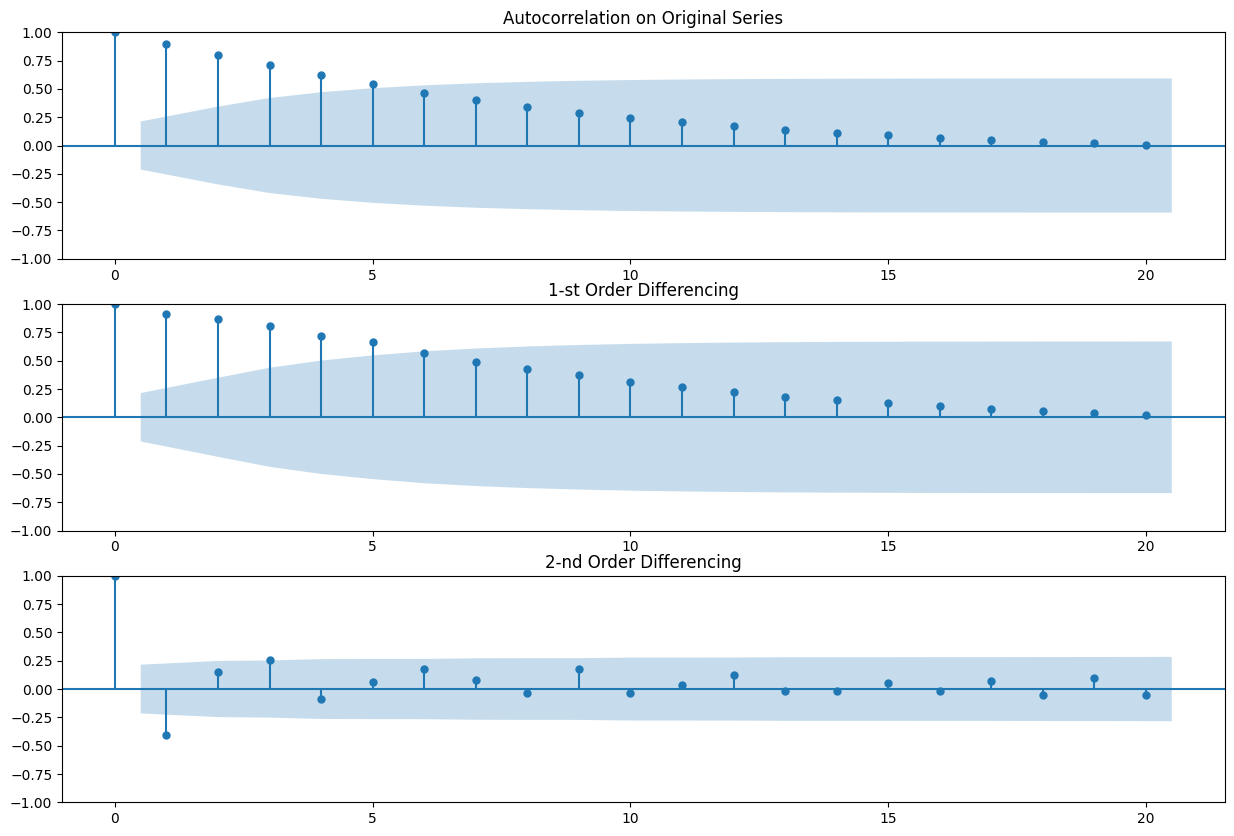

In [77]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(311)
fig = plot_acf(A, ax=ax1,
               title="Autocorrelation on Original Series") 
ax2 = fig.add_subplot(312)
fig = plot_acf(A.diff().dropna(), ax=ax2, 
               title="1-st Order Differencing")
ax3 = fig.add_subplot(313)
fig = plot_acf(A.diff().diff().dropna(), ax=ax3, 
               title="2-nd Order Differencing")

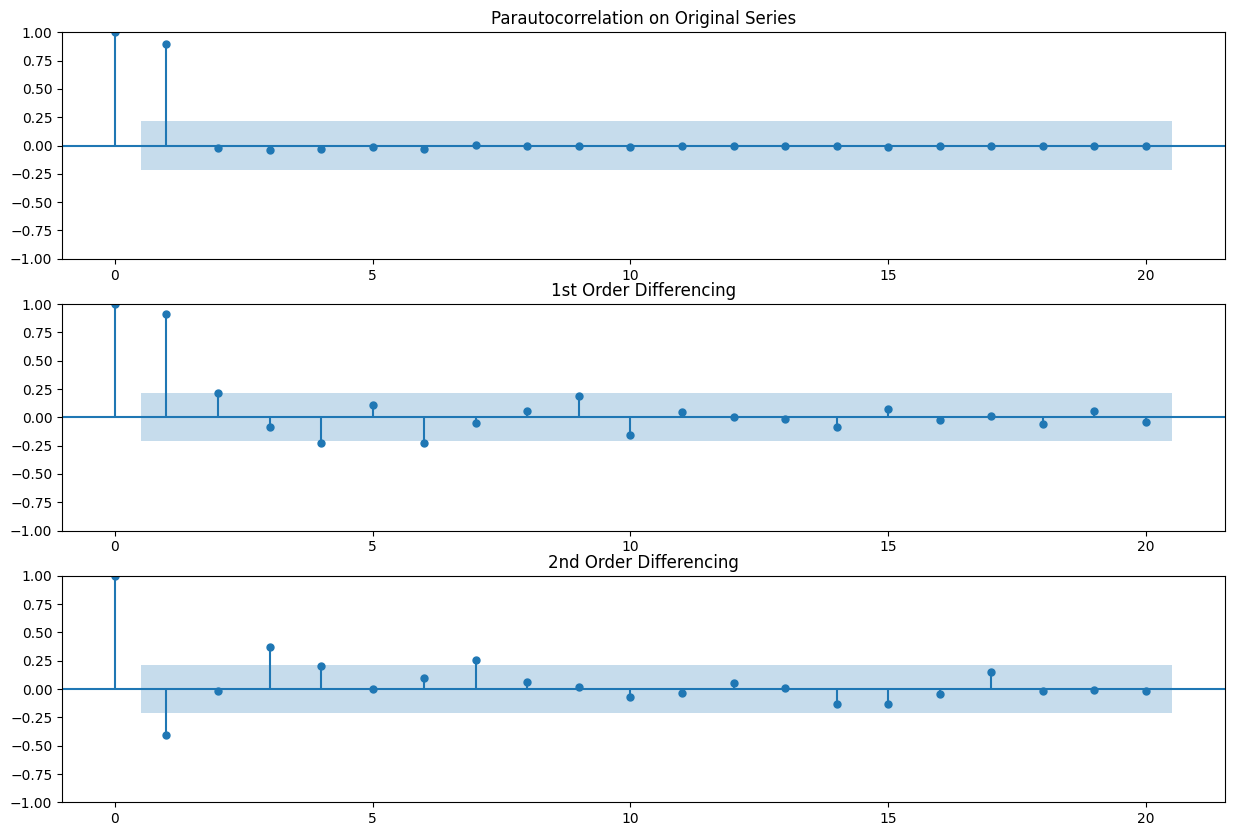

In [78]:
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(311)
fig = plot_pacf(A, ax=ax1,
               title="Parautocorrelation on Original Series") 
ax2 = fig.add_subplot(312)
fig = plot_pacf(A.diff().dropna(), ax=ax2, 
               title="1st Order Differencing")
ax3 = fig.add_subplot(313)
fig = plot_pacf(A.diff().diff().dropna(), ax=ax3, 
               title="2nd Order Differencing")

### Примем уровень значимости автокорреляции 0,25. Исходя из принятых значений в первом приближении примем порядок авторегрессии равный 1, а порядок скользящего среднего равный 1.

После стабилизации ряда (удаления тренда) смотрим:
- Если ACF обрывается после лага q → это MA(q) компонента.
- Если PACF обрывается после лага p → это AR(p) компонента.

## 3.3 Реализация процесса моделирования и прогнозирования

                               SARIMAX Results                                
Dep. Variable:                    RUS   No. Observations:                   85
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -598.980
Date:                 Пн, 23 июн 2025   AIC                           1203.960
Time:                        22:42:50   BIC                           1211.217
Sample:                    01-31-2020   HQIC                          1206.875
                         - 04-24-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4449      0.164     -2.719      0.007      -0.766      -0.124
ma.L1          0.0539      0.146      0.371      0.711      -0.231       0.339
sigma2      1.084e+05   7433.931     14.584      0.0

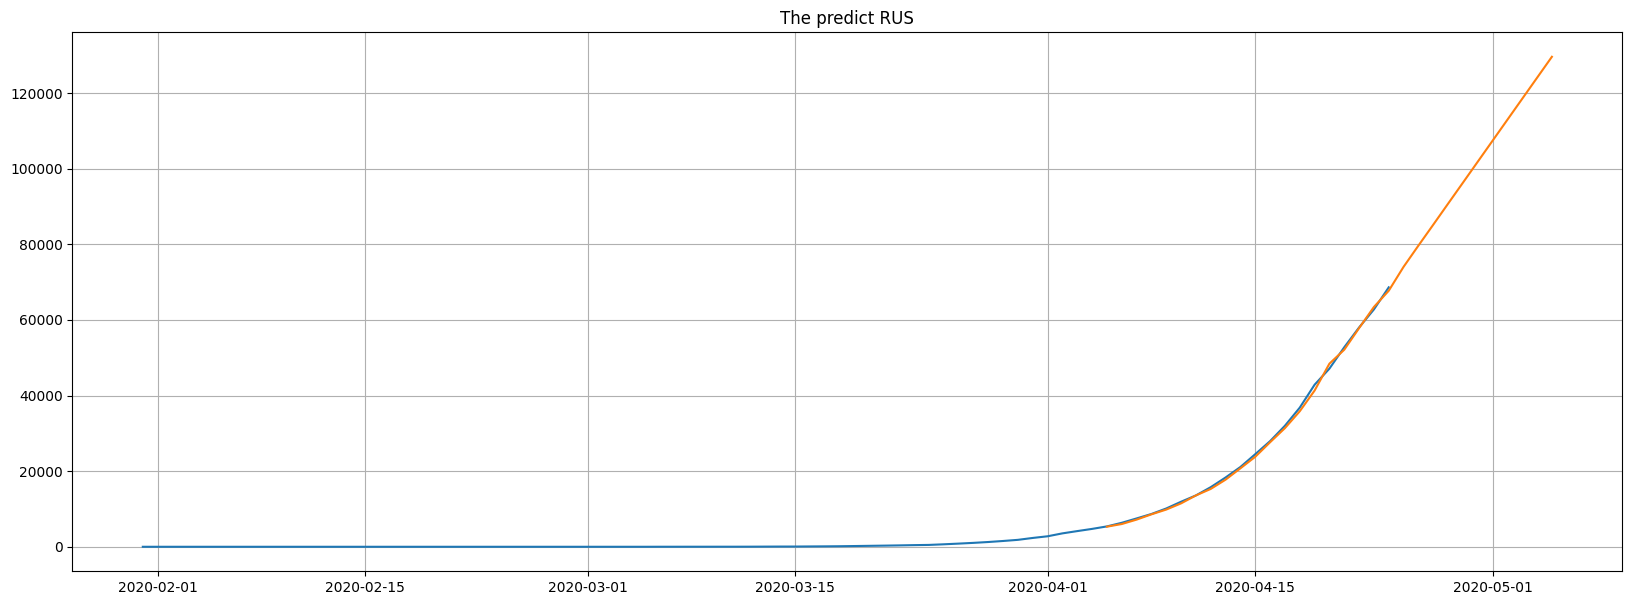

In [90]:
from statsmodels.tsa.arima_model import ARIMA #Подключение библиотеки
mod = sm.tsa.arima.ARIMA(A, order=(1, 2, 1), trend='n'); # Задание параметров модели
res = mod.fit()
print(res.summary())
print(res.predict(len(A),len(A)+10));
plt.figure(figsize=(20, 7));
plt.title('The predict RUS');
plot(A);
grid();
plot(res.predict(len(A)-20,len(A)+10));
plt.show()

## 3.4 Проверка адекватности модели.
### Для проверки адекватности модели выполним анализ остатков (ошибок) моделирования.

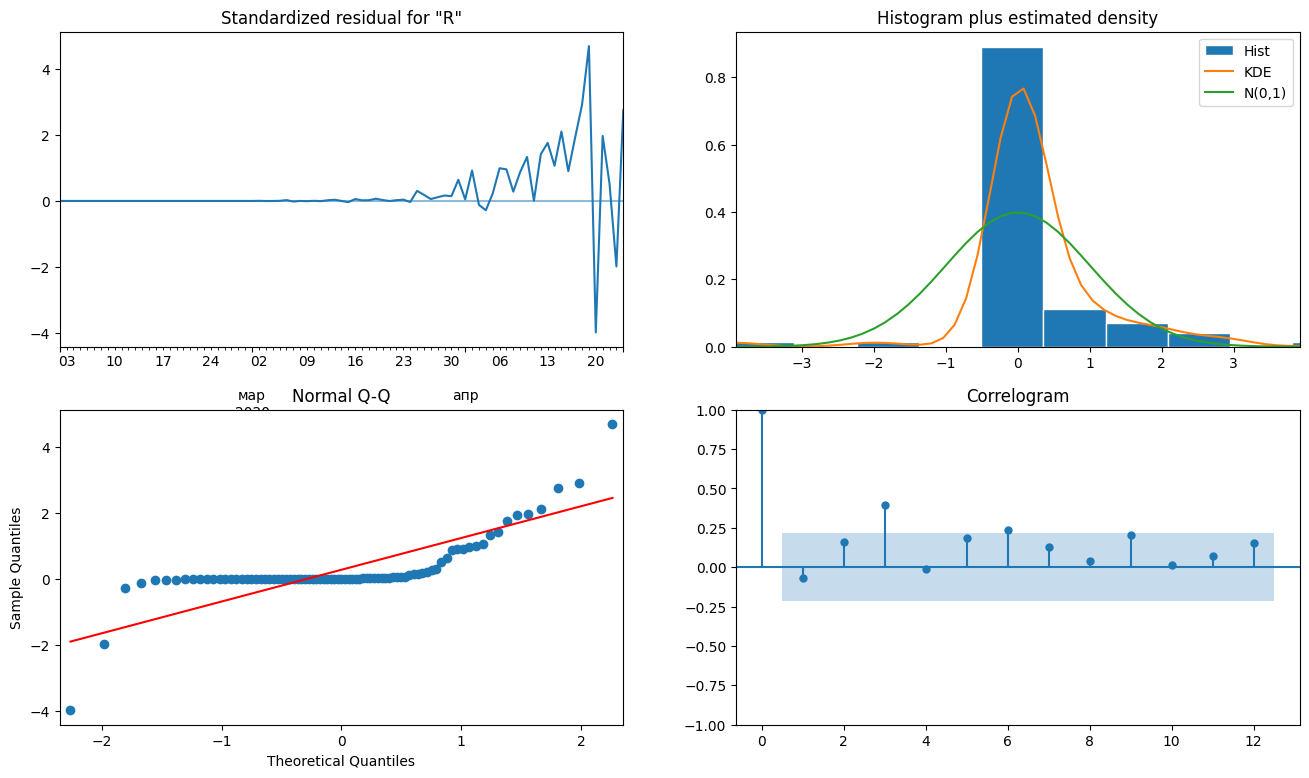

In [82]:
fig = plt.figure(figsize=(16,9))
fig = res.plot_diagnostics(fig=fig, lags=12)

### Принимая во внимание небольшое количество данных, примем модель "условно" адекватной, однако ее лучше уточнить. Опасение вызывает отклонение результатов от требований теоремы Маркова-Гаусса. 

In [91]:
import pmdarima as pm;

In [94]:
model_2 = pm.auto_arima(A, start_p=0, start_q=0,
                      test='adf',
                      max_p=10, max_q=10,
                      m=2,             
                      d=2,          
                      seasonal=False,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='trace',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1211.529, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1196.878, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=1201.935, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1212.844, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1198.891, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1198.889, Time=0.07 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=1191.496, Time=0.15 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=1181.341, Time=0.16 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=1181.792, Time=0.07 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=1183.121, Time=0.21 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=1183.134, Time=0.20 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=1190.046, Time=0.21 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=1181.999, Time=0.11 sec
 ARIMA(4,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(3,2,1)(0,0,0)[0]             : 

                               SARIMAX Results                                
Dep. Variable:                    RUS   No. Observations:                   85
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -598.980
Date:                 Пн, 23 июн 2025   AIC                           1203.960
Time:                        22:52:26   BIC                           1211.217
Sample:                    01-31-2020   HQIC                          1206.875
                         - 04-24-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4449      0.164     -2.719      0.007      -0.766      -0.124
ma.L1          0.0539      0.146      0.371      0.711      -0.231       0.339
sigma2      1.084e+05   7433.931     14.584      0.0

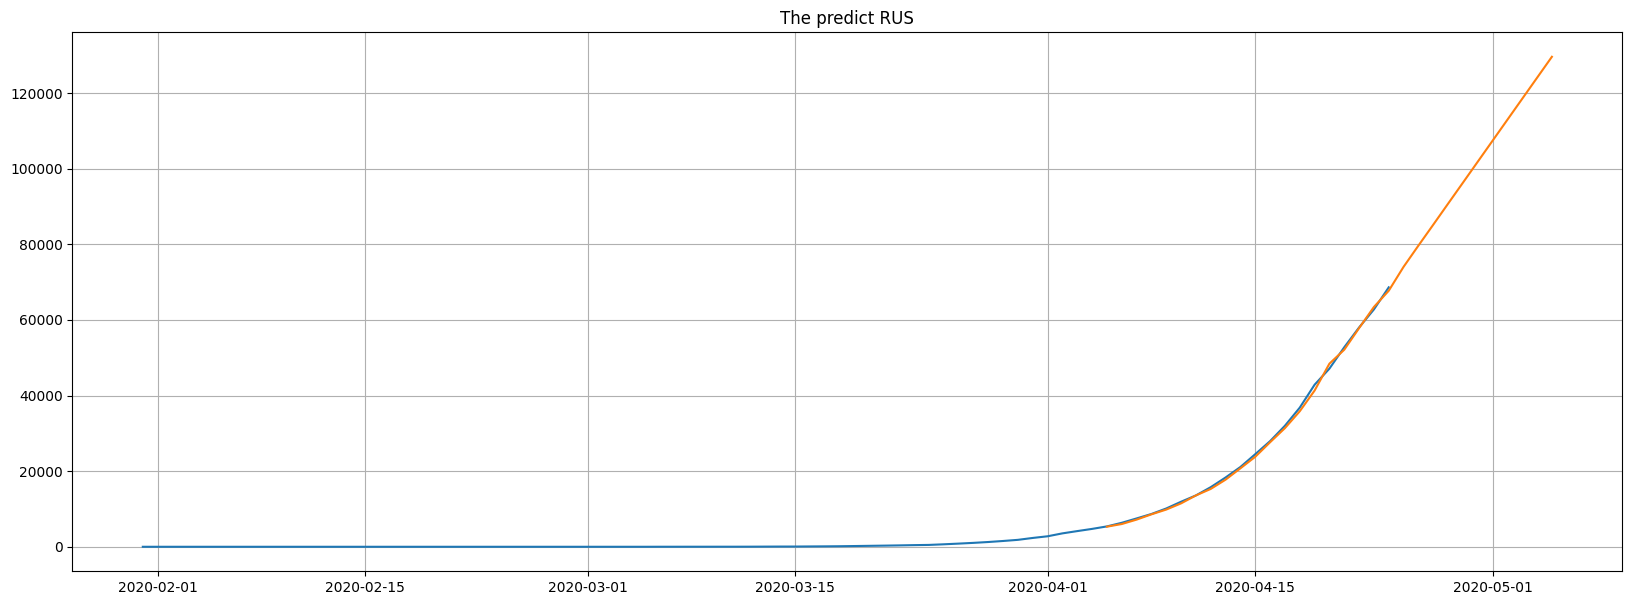

In [100]:
mod_2 = sm.tsa.arima.ARIMA(A, order=(3, 2, 1), trend='n'); # Задание параметров модели
res_2 = mod.fit()
print(res_2.summary())
print(res_2.predict(len(A),len(A)+10));
plt.figure(figsize=(20, 7));
plt.title('The predict RUS');
plot(A);
grid();
plot(res_2.predict(len(A)-20,len(A)+10));
plt.show()

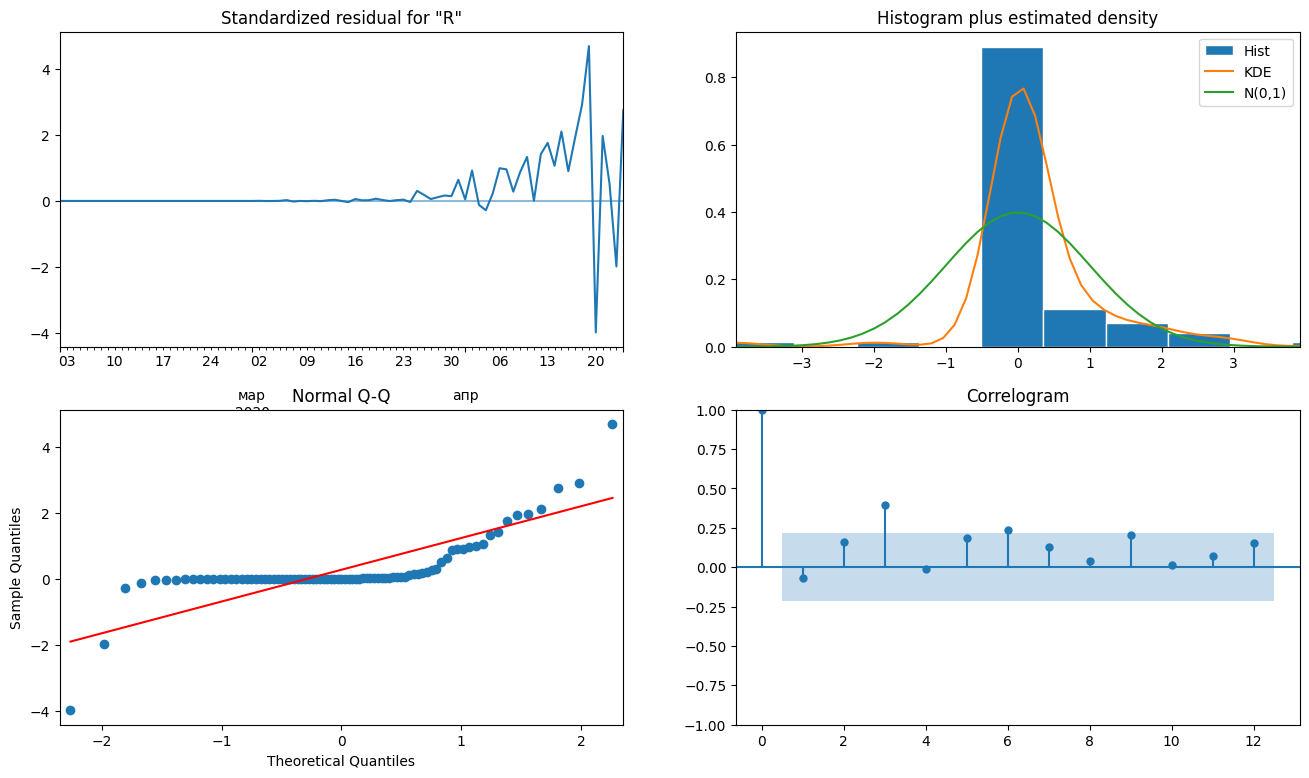

In [101]:
fig = plt.figure(figsize=(16,9))
fig = res_2.plot_diagnostics(fig=fig, lags=12)

Результат остался прежним. В следующей работе применим LSTM или RandomForestRegressor.

## Список литературы
1. Box G.E., Jenkins G.M., Reinsel G.C. Time Series Analysis, Forecasting and Control, Prentice Hall, 1994. 
2. Durbin J., Koopman S.J. Time Series Analysis by State Space Methods, Oxford University Press, 2005. 
3. Emmenegger J.-F. , Pervukhina E., Golikova V. Cointegration analysis of cargo volume time series of the tracking industry of Ukraine, to be published. 
4. Engle R.E., Granger C.W.J. Cointegration and Error Correction: Representation, Estimation and Testing, Econometrica, 1987, Vol. 55, P.251-276.
5. Johansen S. Likelihood-based Inference in Cointegrated Vector Autoregressive Models, Oxford University Press, 1995. 
6.  Juselius K. The Cointegrated VAR Model, Oxford University Press, 2006.
7. Golikova V., Pervukhina E., Emmenegger J.-F., Cointegration: a Tool to Analyze Cargo Ukrainian Transport // Abstracts of The Fifth International Conference of Applied Mathematics and Computing. Plovdiv, Bulgaria, August 2008, 12-17, P. 359.  
8. Hamilton J.D. Time Series Analysis, Princeton University Press, 1994.  
9. Hansen H. CATS in RATS: Cointegration Analysis of Time Series, Handbook for the software package CATS. - Illinois: ESTIMA, 1995.
10. Harvey A. C. Forecasting, structural time series models and Kalman filter, Cambridge, Cambridge University Press, 1996.
11. Hendry D.F. Dynamic Econometrics, Oxford University Press, 1995. 
12. Kalman R. E. A New Approach to Linear Filtering and Prediction Problems. // Transaction of the ASME. Journal of Basic Engineering. Vol. 82D. 1960. March. P. 35-45.
13. Pervukhina E. Use of Information Measure in Procedures for Estimation of Discrete Stochastic Systems at Unknown Noises Covariance, Transactions of Russian Academy of Natural Sciences, Series “Mathematics. Mathematical Modeling. Informatics and Control”, Vol. 3, N3, pp. 100-106, 1999 (in Russian).
14. Pervukhina, E., Emmenegger J.-F. Adaptive time series filters obtained by minimization of the Kullback-Leibler divergence criterion // International Journal of Applied Mathematics, 2005, Vol. 17, № 1, P.69-89.
15. Pervukhina E., Emmenegger J.-F., Bardadym T., Serbinenko A. ARIMA, cointegration, Kalman-filter, α -stable distributions // PAMM • Proc. Appl. Math. Mech. 7, 1081601–1081602 (2007) / DOI 10.1002/pamm.200700150.
16. Pervukhina E. Adaptive Time Series Filters to Smooth and Forecast Economic Variables // Abstracts of International Conference on Industrial and Applied Mathematics ICIAM2007, Zurich, Switzerland, 16-20 July, 2007, Minisymposium Nr: IC/MP/008/J/77.
17. Pervukhina E., Emmenegger J.-F. Examples of Adaptive Time Series Filtering under Incomplete a priori Information // Abstracts of Swiss Statistics Meeting, Zurich, Switzerland, 9-11 November, 2005. – P. 53.
18. Pervukhina E., Emmenegger J.-F., Adaptive Time Series Filters to Smooth and Forecast Economic Variables // PAMM – Volume 7, Issue 1 (Special Issue: Sixth International Congress on Industrial Applied Mathematics (ICIAM07) and GAMM Annual Meeting, Zürich 2007), Date: December 2007, Pages: 1081605-1081606, http://www3.interscience.wiley.com/journal/91016652/home
19. Pervukhina E. To the estimation of the state and parameters in discrete stochastic systems on the information criterion. To be published.
